In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devmk98","key":"4d23bdced23fe4a646cfeda69408bb72"}'}

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:22<00:00, 164MB/s]
100% 2.29G/2.29G [00:22<00:00, 107MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [53]:
# import libraries
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from IPython.display import Image, display
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Activation, Dropout, BatchNormalization
)
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [7]:
import os
import pandas as pd

data_dir = '/content/chest_xray/train'

filepaths = []
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)

        labels.append(fold)

data = {'filepaths': filepaths, 'labels': labels}
df = pd.DataFrame(data)


In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(temp_df, train_size=0.6, shuffle=True, random_state=123)


In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

def preprocess_image(img):
    return img

data_gen_args = dict(
    preprocessing_function=preprocess_image,
)

train_gen = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_image).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(train_gen.class_indices)

base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006),
          bias_regularizer=l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7304514 (27.86 MB)
Trainable params: 721881

In [20]:
batch_size = 16
epochs = 1

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False
)

261/261 [==============================] - 3220s 12s/step - loss: 3.1186 - accuracy: 0.9549 - val_loss: 1.8134 - val_accuracy: 0.9665


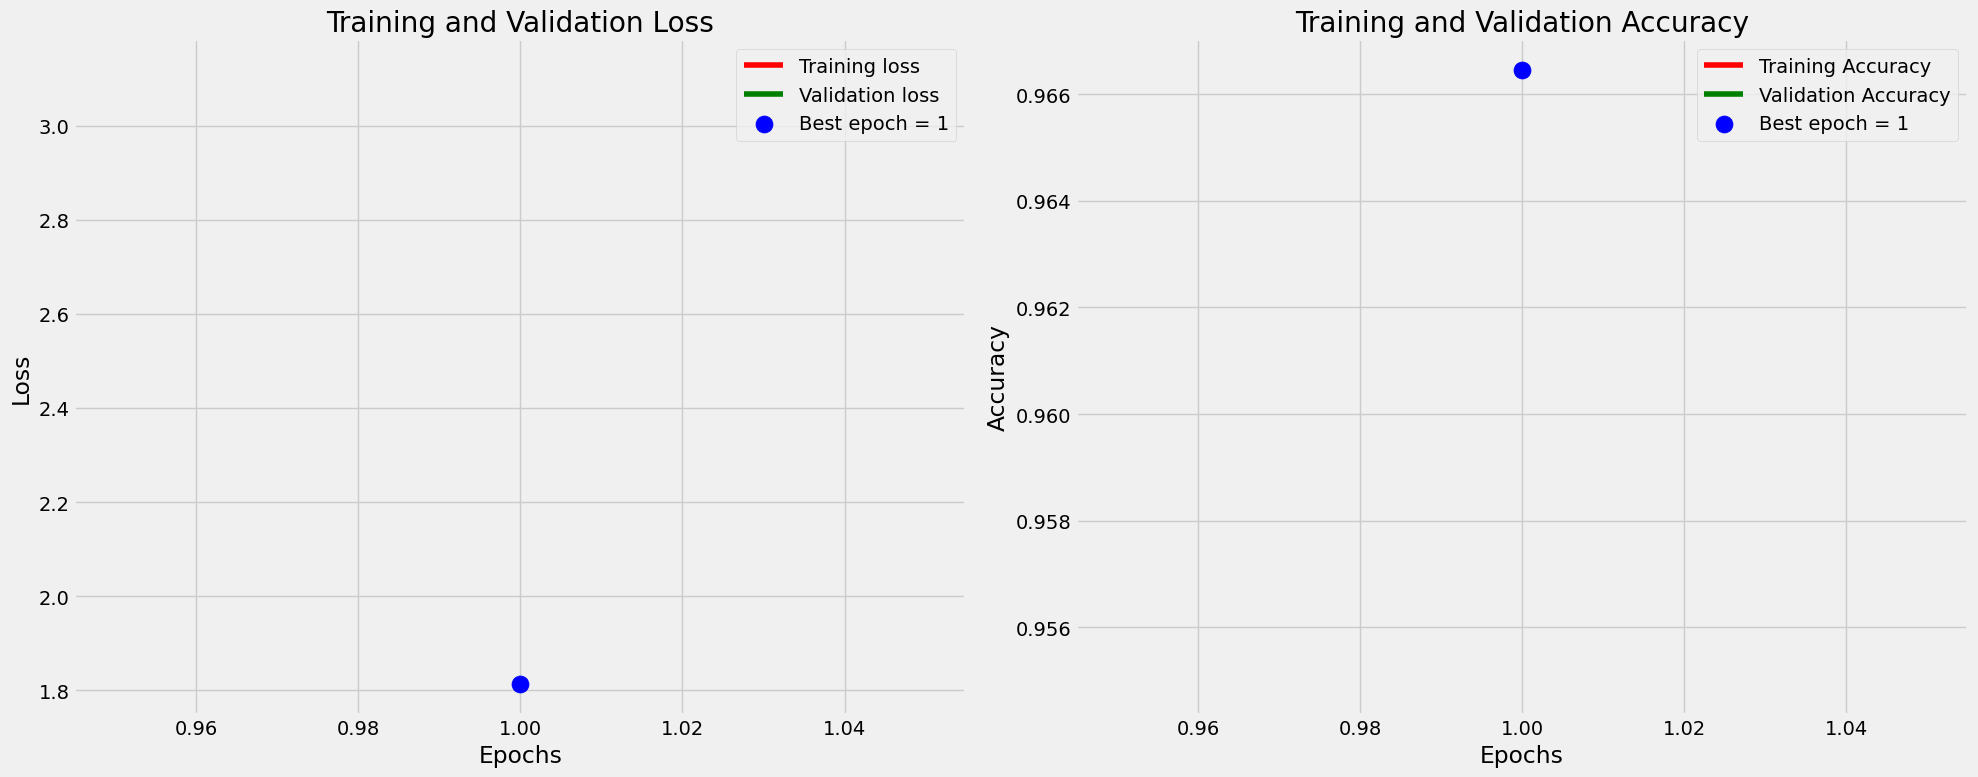

In [46]:
import matplotlib.pyplot as plt
import numpy as np

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 69s 6s/step - loss: 1.8038 - accuracy: 0.9713
Train Loss:  1.7749577760696411
Train Accuracy:  0.9715909361839294
--------------------
Validation Loss:  1.8258801698684692
Validation Accuracy:  0.9602272510528564
--------------------
Test Loss:  1.8037773370742798
Test Accuracy:  0.9712918400764465


In [23]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

11/11 [==============================] - 73s 6s/step


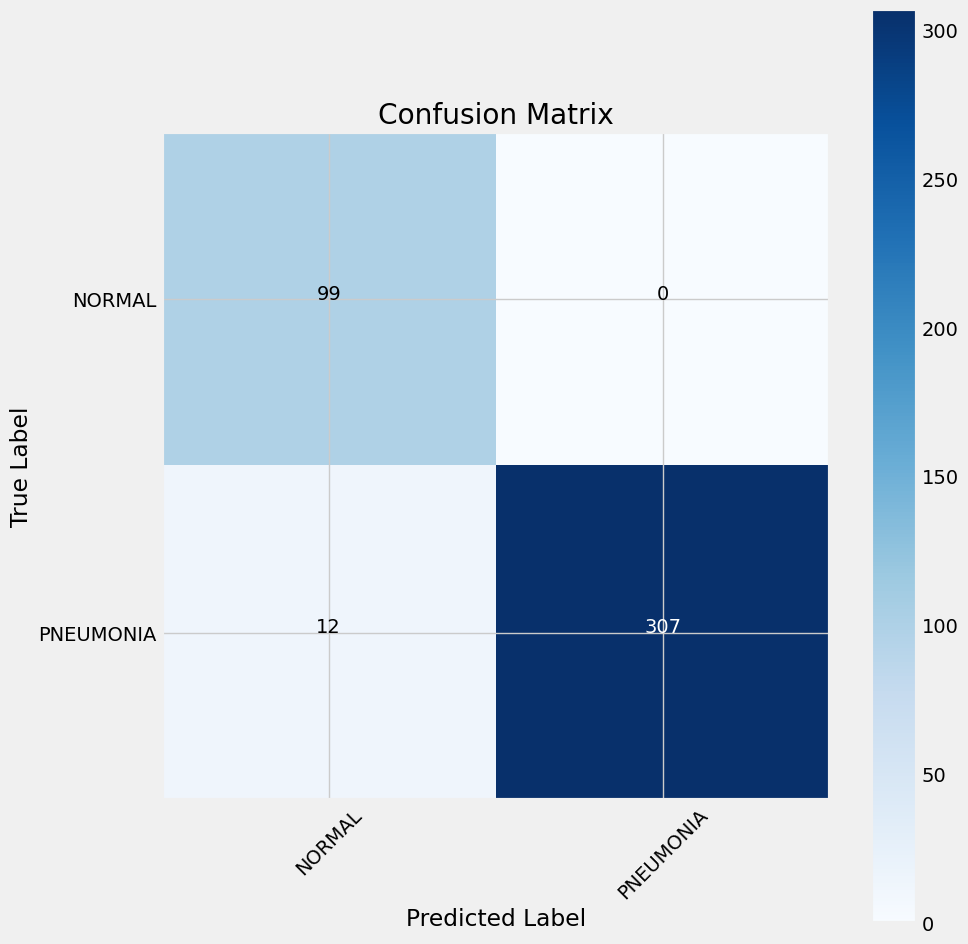

In [48]:
from sklearn.metrics import confusion_matrix
import itertools

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.89      1.00      0.94        99
   PNEUMONIA       1.00      0.96      0.98       319

    accuracy                           0.97       418
   macro avg       0.95      0.98      0.96       418
weighted avg       0.97      0.97      0.97       418



In [57]:
model.save('Pneumonia_Detection.h5')

In [29]:
loaded_model = tf.keras.models.load_model('Pneumonia_Detection.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
image_path = '/content/chest_xray/test/PNEUMONIA/person3_virus_15.jpeg'
image = Image.open(image_path)

if image.mode != 'RGB':
    image = image.convert('RGB')

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
predicted_class = class_labels[tf.argmax(score)]

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 192ms/step
Predicted Class: Pneumonia


1/1 [==============================] - 3s 3s/step


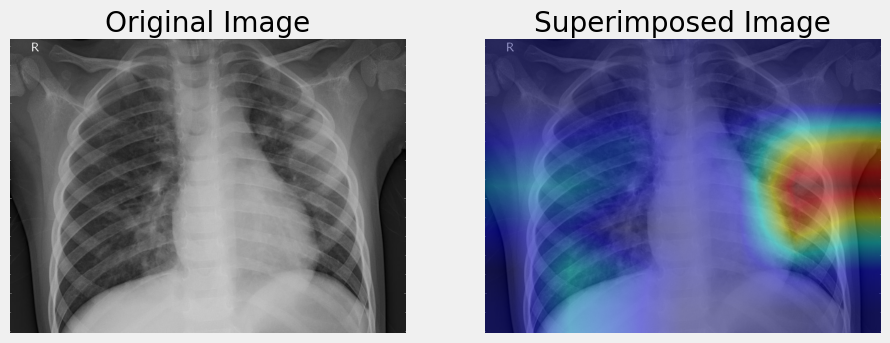

In [54]:
model = ResNet50(weights='imagenet')
img_path = '/content/chest_xray/test/PNEUMONIA/person3_virus_15.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
class_index = np.argmax(preds[0])
last_conv_layer = model.get_layer('conv5_block3_out')
cam_model = tf.keras.Model(inputs=model.input, outputs=(last_conv_layer.output, model.output))

with tf.GradientTape() as tape:
    last_conv_output, preds = cam_model(x)
    class_output = preds[:, class_index]

grads = tape.gradient(class_output, last_conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_output = last_conv_output[0]
heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
original_img = cv2.imread(img_path)
height, width, _ = original_img.shape
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (width, height))
heatmap = (heatmap * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
cv2.imwrite('cam.jpg', superimposed_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.show()